# Multiple symbolic inputs to model

This notebook is meant to explore the opportunity for adding multiple symbolic inputs and outputs to a model *while training* and then remove them after in order to get a proper function $(t,x)\mapsto \hat{q}$. During training we want to input the stencil [TC,BL,BC,BR].

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import utils
plt.style.use('ggplot')
tfkl = tf.keras.layers

In [66]:
# TC = tfkl.Input(shape=(1,))
BL = tfkl.Input(shape=(1,), name='L')
BC = tfkl.Input(shape=(1,), name='C')
BR = tfkl.Input(shape=(1,), name='R')

h1 = tfkl.Dense(30, activation='relu', kernel_initializer='he_uniform')
h2 = tfkl.Dense(30, activation='relu', kernel_initializer='he_uniform')
h3 = tfkl.Dense(30, activation='relu', kernel_initializer='he_uniform')
out = tfkl.Dense(1, activation='linear')
def feed(inp):
    return out(h3(h2(h1(inp))))
# Want to recieve a single tensor with all outputs, so we concatenate them
concat = tf.concat([feed(BL), feed(BC), feed(BR)], axis=1)
model = tf.keras.Model(inputs=[BL,BC,BR], outputs=concat)
# model.summary()

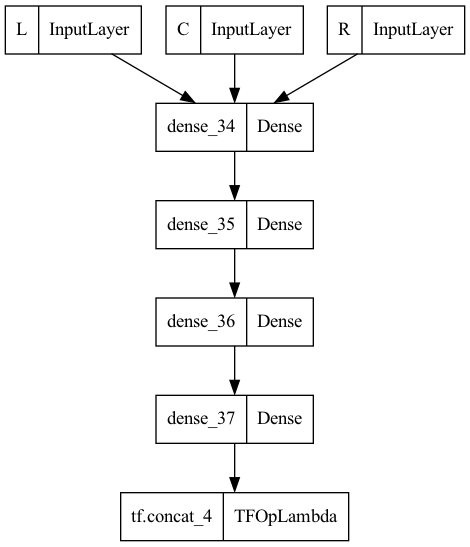

In [67]:
tf.keras.utils.plot_model(model, 'multimodel.png')

In [68]:
# Lets say we want to learn the sin function, and our loss function only works with 4 computed values
q = lambda x: np.sin(2*np.pi*x)
# Input must contain all three stencil points
x_c = np.linspace(-1,1,100)
x_l = np.roll(x_c, 1)
x_r = np.roll(x_c, -1)
X = np.column_stack([x_l, x_c, x_r])
y = q(X)
print(X.shape, y.shape)

(100, 3) (100, 3)


In [69]:
mse = tf.keras.losses.mean_squared_error
def loss(true, pred):
    TL, TC, TR = tf.unstack(true, axis=1)
    PL, PC, PR = tf.unstack(pred, axis=1)
    return mse(TL,PL) + mse(TC,PC) + mse(TR,PR)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.005), loss=loss)

In [70]:
hist = model.fit([X[:,0], X[:,1], X[:,2]], y, batch_size=16, epochs=200, verbose=0, callbacks=[utils.LowkeyLogger(50)]) # type: ignore

2023-02-27 15:33:55.484504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch =    0  loss = 1.74e+00 
epoch =   50  loss = 2.86e-01 
epoch =  100  loss = 2.18e-01 
epoch =  150  loss = 1.55e-01 


In [71]:
num_inputs = 3
model_core = tf.keras.models.Sequential(model.layers[num_inputs:-1])

In [72]:
xgrid = np.linspace(-1.5,1.5,300)
preds = model_core(xgrid.reshape((-1,1)))
print(preds.shape)

(300, 1)


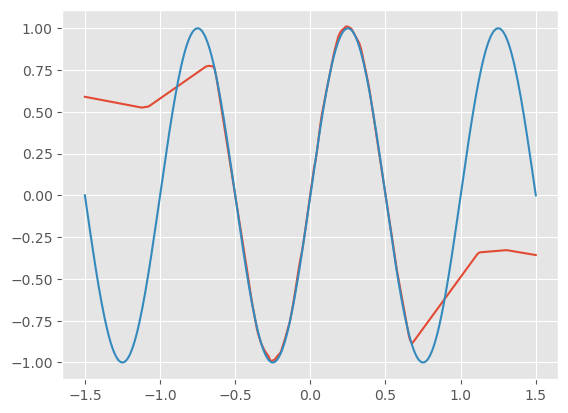

In [73]:
plt.plot(xgrid, preds.numpy().flatten(), label='Preds')
plt.plot(xgrid, q(xgrid), label='True')

In [68]:
tgrid = np.linspace(0,1,5)[:-1]
xgrid = np.linspace(0,1,5)[:-1]
k = tgrid[1] - tgrid[0]

In [69]:
# TC = np.meshgrid(tgrid+k, xgrid)
P = np.meshgrid(tgrid, xgrid)
# CL = np.meshgrid(tgrid, np.roll(xgrid,1))

tp, xp = [a.flatten() for a in P]
tn = tp+k
xw = np.roll(xp, len(tgrid))
xe = np.roll(xp, -len(tgrid))

north = np.column_stack([tn, xp])
point = np.column_stack([tp, xp])
west = np.column_stack([tp, xw])
east = np.column_stack([tp, xe])

print(point)
print()
print(east)


[[0.   0.  ]
 [0.25 0.  ]
 [0.5  0.  ]
 [0.75 0.  ]
 [0.   0.25]
 [0.25 0.25]
 [0.5  0.25]
 [0.75 0.25]
 [0.   0.5 ]
 [0.25 0.5 ]
 [0.5  0.5 ]
 [0.75 0.5 ]
 [0.   0.75]
 [0.25 0.75]
 [0.5  0.75]
 [0.75 0.75]]

[[0.   0.25]
 [0.25 0.25]
 [0.5  0.25]
 [0.75 0.25]
 [0.   0.5 ]
 [0.25 0.5 ]
 [0.5  0.5 ]
 [0.75 0.5 ]
 [0.   0.75]
 [0.25 0.75]
 [0.5  0.75]
 [0.75 0.75]
 [0.   0.  ]
 [0.25 0.  ]
 [0.5  0.  ]
 [0.75 0.  ]]


In [22]:
print(tgrid.flatten())
print(xgrid.flatten())

[0.  0.5 1.  0.  0.5 1.  0.  0.5 1. ]
[0.  0.  0.  0.5 0.5 0.5 1.  1.  1. ]


In [74]:
yoyo, okay = [tf.keras.layers.Input(shape=2)]*2
# in1 = tf.keras.layers.Input(shape=2)
# in2 = tf.keras.layers.Input(shape=2)
print(yoyo, okay)

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'") KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'")


In [76]:
print(yoyo is okay)

True


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-01 13:41:51.362317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-01 13:41:51.362661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


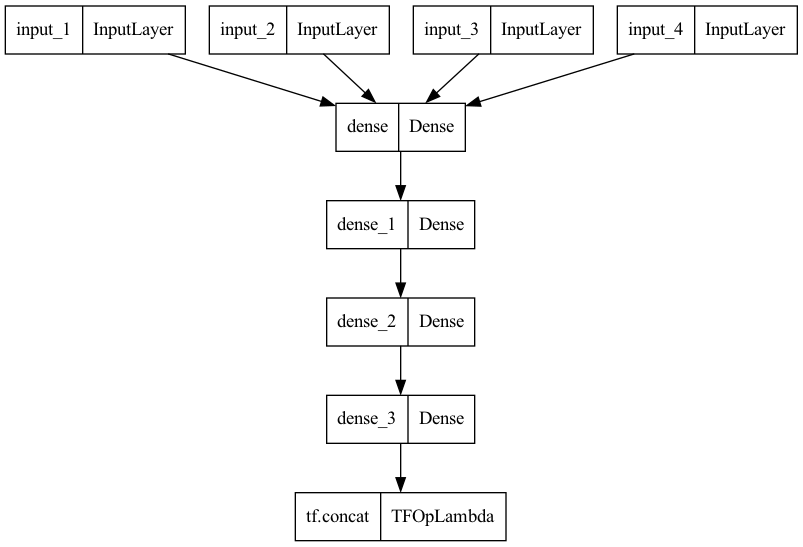

In [2]:
model = utils.get_multisymbolic_model()
tf.keras.utils.plot_model(model, 'multimodel.png')

## Production model testing

In [2]:
model = tf.keras.models.load_model('models/multisymbolic/')
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-07 14:36:32.693343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-07 14:36:32.693377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                120       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________


In [3]:
x = np.linspace(-1,1,101)[:-1]
t = np.ones(shape=x.shape)
preds = model(np.column_stack([t, x]))
preds = preds.numpy().flatten()

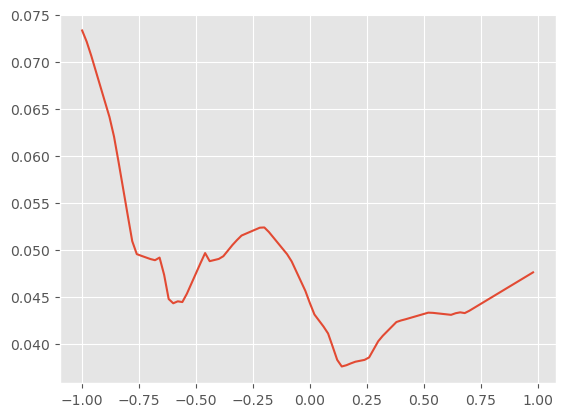

In [4]:
plt.plot(x, preds)

In [8]:
F = lambda u: u**2/2
init = lambda x: .5*np.sin(np.pi*x)
# q = lambda t,x: np.where(abs(x+.5)<0.2, 0.5, 0)
q = lambda t,x: np.exp(-50*(x+.5)**2)/3# * np.cos(2*np.pi*t) #np.where(abs(x+.5)<0.2, np.exp(-10*(x-.5)**2), 0)

In [9]:
from burgers_LW import Solver
def q_mod(t,x):
    t_arr = np.ones(shape=x.shape) * t
    return tf.cast(model(np.column_stack([t_arr,x])), dtype=np.float64).numpy().flatten()
true_solver = Solver(F, init, q, M=100)
model_solver = Solver(F, init, q_mod, M=100)
path = true_solver.solve()
pathhat = model_solver.solve()

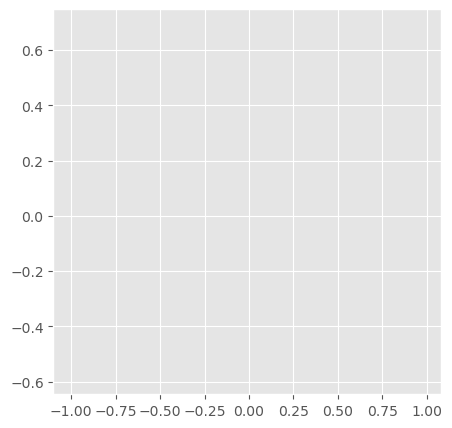

In [10]:
utils.animate('TEST.mp4', t, x, pathhat, path)

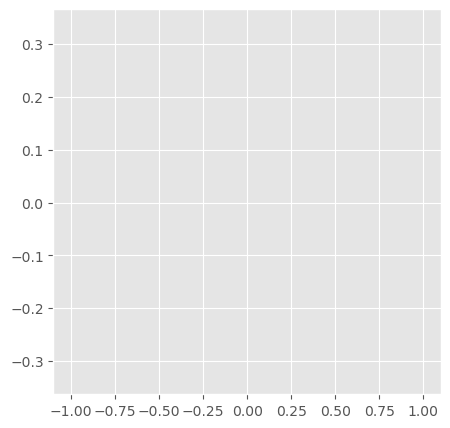

In [83]:
def get_model_source():
    t, x = model_solver.tgrid, model_solver.xgrid
    t, x = np.meshgrid(t, x)
    shape = t.shape
    t, x = t.flatten(), x.flatten()
    return model(np.column_stack([t,x])).numpy().reshape(shape)

utils.animate('TEST2.mp4', true_solver.tgrid, true_solver.xgrid, true_solver.get_source()) #get_model_source(), true_solver.get_source())